In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [ ]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(10 , activation='sigmoid')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 1.2024 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.3651 - val_sparse_categorical_accuracy: 0.9077
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3354 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.2700 - val_sparse_categorical_accuracy: 0.9245
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2666 - sparse_categorical_accuracy: 0.9264 - val_loss: 0.2304 - val_sparse_categorical_accuracy: 0.9326
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2218 - sparse_categorical_accuracy: 0.9382 - val_loss: 0.2048 - val_sparse_categorical_accuracy: 0.9400
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1914 - sparse_categorical_accuracy: 0.9455 - val_loss: 0.1852 - val_sparse_categorical_accuracy: 0.9466
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1745 - sparse_categorical_accuracy: 0.9499 - val_loss: 0.1681 - val_sparse_categorical_accuracy: 0.9509
Epoch 7/10
46

In [ ]:
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    print(f"Layer {i}: {layer.name}")

    if weights:
        W, b = weights  # W: weights matrix, b: bias vector
        print(f"  Weights shape: {W.shape}")
        print(f"  Biases shape: {b.shape}")
    else:
        print("  No weights (probably a Flatten layer)")


Layer 0: flatten
  No weights (probably a Flatten layer)
Layer 1: dense
  Weights shape: (784, 64)
  Biases shape: (64,)
Layer 2: dense_1
  Weights shape: (64, 10)
  Biases shape: (10,)


In [ ]:
import numpy as np

# 1. Scale weights and biases proportionally to fit within [-1, 1]
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if weights:  # Only Dense layers have weights
        W, b = weights
        W_max = np.max(np.abs(W))
        b_max = np.max(np.abs(b))

        W_scaled = W  if W_max != 0 else W
        b_scaled = b if b_max != 0 else b

        layer.set_weights([W_scaled, b_scaled])
        print(f"Scaled Layer {i} ({layer.name}) weights and biases into [-1, 1]")

# 2. Save scaled weights and biases to a file
weights_dict = {}
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if weights:
        W, b = weights
        weights_dict[f"layer_{i}_weights"] = W
        weights_dict[f"layer_{i}_biases"] = b

np.savez("scaled_weights.npz", **weights_dict)
print("✅ Scaled weights saved to 'scaled_weights.npz'")

# 3. Evaluate the model again
loss, accuracy = model.evaluate(ds_test)
print(f"\n🔍 Accuracy after proportional scaling: {accuracy * 100:.2f}%")


Scaled Layer 1 (dense) weights and biases into [-1, 1]
Scaled Layer 2 (dense_1) weights and biases into [-1, 1]
✅ Scaled weights saved to 'scaled_weights.npz'
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2855 - sparse_categorical_accuracy: 0.9393

🔍 Accuracy after proportional scaling: 93.75%


In [ ]:
np.set_printoptions(precision=4, suppress=True)  # nicer float formatting

for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    print(f"\n📦 Layer {i} - {layer.name}")

    if weights:
        W, b = weights

        print(f"  🧮 Weights (shape {W.shape}):\n{W}")
        print(f"  🎯 Biases (shape {b.shape}):\n{b}")
    else:
        print("  🚫 No weights or biases (probably Flatten or non-trainable)")



📦 Layer 0 - flatten_26
  🚫 No weights or biases (probably Flatten or non-trainable)

📦 Layer 1 - dense_52
  🧮 Weights (shape (784, 64)):
[[ 0.01    0.0526 -0.052  ... -0.0619  0.0209 -0.0325]
 [-0.0067 -0.0657 -0.0454 ... -0.0385  0.0505  0.0351]
 [ 0.0698  0.0105 -0.0556 ... -0.0096  0.0026  0.0008]
 ...
 [-0.0638 -0.0602  0.0699 ...  0.0195 -0.0407  0.0688]
 [-0.0494  0.0241 -0.0479 ... -0.0115  0.0587 -0.0638]
 [-0.0529  0.0064  0.026  ...  0.0231  0.0349  0.001 ]]
  🎯 Biases (shape (64,)):
[-0.0784  0.5846  0.0934 -0.2774 -0.0188 -0.5927  0.0186 -0.3744 -0.1269
 -0.6147  0.4202  0.8733 -0.108  -0.4086  0.8722  0.8987 -0.5914  0.0094
 -0.5138 -0.1655  0.3967  0.1571 -0.4516  0.3727  1.      0.38    0.8993
  0.5807 -0.0974  0.0509  0.4611 -0.1115  0.9262  0.3609  0.7763 -0.5156
  0.1357  0.2231  0.1356  0.7859 -0.6142 -0.4101  0.0506 -0.3718 -0.3997
 -0.7117  0.7448 -0.5013  0.6166 -0.0689 -0.4776  0.4141  0.1494 -0.5433
  0.3707  0.2055 -0.5604 -0.5302  0.4937  0.1055 -0.6592 -0.83

In [ ]:
# List to hold 2D weight matrices from each Dense layer
weight_matrices = []

for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if weights:  # Skip Flatten and non-trainable layers
        W, _ = weights  # We only use weights, not biases
        weight_matrices.append(W)

# Convert list of 2D arrays to a 3D object array (since each 2D array can be different shape)
weights_3d = np.array(weight_matrices, dtype=object)
print(weights_3d.shape)
# Let's confirm by printing
for i, w in enumerate(weights_3d):
    print(f"\n📦 weights_3d[{i}] shape: {w.shape}")
    print(w)


(2,)

📦 weights_3d[0] shape: (784, 64)
[[-0.0404  0.0175  0.0349 ... -0.0367  0.0332  0.0368]
 [ 0.0502  0.006   0.053  ...  0.0431 -0.0429  0.0043]
 [-0.0357 -0.0631 -0.0229 ... -0.0581  0.0068 -0.0099]
 ...
 [ 0.0349  0.0302  0.0576 ... -0.0651 -0.0621  0.0737]
 [-0.0685  0.0301 -0.0584 ...  0.0332 -0.0072  0.0522]
 [ 0.0221 -0.0258 -0.0322 ...  0.0641 -0.021   0.0266]]

📦 weights_3d[1] shape: (64, 10)
[[-0.7513 -0.551  -0.5196 -0.2909  0.3418  0.5205 -0.6841  0.3352  0.0804
   0.0871]
 [-0.3494 -0.4796  0.1148  0.2103 -0.3412 -0.1329  0.1632  0.0236 -0.0909
   0.5239]
 [ 0.2174 -0.5927 -0.3625  0.3627  0.3058 -0.2927 -0.5054  0.3029 -0.3606
   0.3587]
 [-0.6157  0.4076  0.2998  0.2292  0.4464 -0.1854 -0.5913  0.3386 -0.066
  -0.2397]
 [-0.2541  0.3129  0.312   0.5335  0.0227 -0.3012 -0.7476  0.4464 -0.5422
  -0.2736]
 [ 0.3121  0.1529  0.2676  0.4364 -0.5823 -0.3679 -0.3048  0.0852  0.3537
  -0.3922]
 [-0.4397 -0.0741 -0.034   0.1825  0.3738 -0.7583 -0.2857 -0.3135  0.5854
   0.371 

In [ ]:
#let n be the number of neurons in this layer and m be the number of neurons in the next layer
n_layers=weights_3d.shape[0]
print(n_layers)
iterative_sequence=[]
for i, w in enumerate(weights_3d):
    print(f"\n📦 weights_3d[{i}] shape: {w.shape}")
    #print(w)
    current_layer=weights_3d[i]
    n=current_layer.shape[0]
    m=current_layer.shape[1]
    if i==0:
        for j in range(784): #no of rows in w matrix
          for k in range(64): #no of cols in w matrix
            iterative_sequence.append(current_layer[j][k]) #for first layer, the shape is neck to neck, so not padding 0s right now.

    else:
        for j in range(64): #row index
          if (j<n):
            for k in range(64): #column index
              if(k<m):
                iterative_sequence.append(current_layer[j][k])
              elif(k>=m):
                  iterative_sequence.append(0)
          elif (j>=n):
            for k in range(64):
              iterative_sequence.append(0)




    print(f"n={n}, m={m}")

2

📦 weights_3d[0] shape: (784, 64)
n=784, m=64

📦 weights_3d[1] shape: (64, 10)
n=64, m=10


Trial on 4x4

In [ ]:
ws=np.array([(1,3,5) , (2,4,6)])
print(ws)
ws.shape


[[1 3 5]
 [2 4 6]]


(2, 3)

In [ ]:
test_seq=[]
n=ws.shape[0]
m=ws.shape[1]
for j in range(4): #row index
  if (j<n):
     for k in range(4): #column index
        if(k<m):
            test_seq.append(ws[j][k])
        elif(k>=m):
            test_seq.append(0)
  elif (j>=n):
      for k in range(4):
              test_seq.append(0)
test_seq=np.array(test_seq)
print(test_seq)

[1 3 5 0 2 4 6 0 0 0 0 0 0 0 0 0]


Mem File Creation

In [ ]:
# Ensure the .mem file exists and is empty before starting
with open("/content/fixed_point_random.mem", "w") as file:
    pass  # This creates the file if it doesn't exist, and clears it if it does

# Start collecting user inputs and writing fixed-point binary
i=0
while (i<len(iterative_sequence)):
    num = float(iterative_sequence[i])
    binary = num * 1024
    a = int(binary)

    if num >= 0:
        binary_16bit = format(a, '016b')
    else:
        binary_16bit = format((1 << 16) + a, '016b')  # Two's complement for negative numbers

    with open("/content/fixed_point_random.mem", "a") as file:
        file.write(binary_16bit + "\n")
    i=i+1


In [ ]:
from google.colab import files

# Path to your .mem file
filepath = "/content/fixed_point_random.mem"

# Trigger download
files.download(filepath)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

for bias

In [ ]:
bias_array=[]

for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if weights:
        _, b = weights  # We only use biases, not weights
        bias_array.extend(b.tolist())
print(len(bias_array))
while (len(bias_array)<128)  :
  bias_array.append(0)
# Ensure the .mem file exists and is empty before starting
with open("/content/bias.mem", "w") as file:
    pass  # This creates the file if it doesn't exist, and clears it if it does

# Start collecting user inputs and writing fixed-point binary
i=0
while (i<len(bias_array)):
    num = float(bias_array[i])
    binary = num * 1024
    a = int(binary)

    if num >= 0:
        binary_16bit = format(a, '016b')
    else:
        binary_16bit = format((1 << 16) + a, '016b')  # Two's complement for negative numbers

    with open("/content/bias.mem", "a") as file:
        file.write(binary_16bit + "\n")
    i=i+1


74


comma ki bakchodi

In [ ]:
# Open the original file in read mode and a new file to write the modified content
with open('/content/sigmoid_bias.txt', 'r') as infile, open('/content/weights_sigmoid_mnist.txt', 'w') as outfile:
    for line in infile:
        line = line.strip()  # remove any newline or trailing whitespace
        if line:  # skip empty lines
            outfile.write(line + ',\n')  # add comma and newline


First Test Case

In [ ]:
for i, (image, label) in enumerate(ds_test):
    if label.numpy().item()== 1:
        print("📍 Found label==1 at index:", i)
        image_np = image.numpy()
        label_true = label.numpy()
        break

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:


import numpy as np
# Grab a batch of test data (just 1 sample)
for c in range(100):
  for image, label in ds_test.take(1):
    if label[c].numpy()==1:
      image_np = image[c].numpy()  # shape: (28, 28)
      label_true = label[c].numpy()
      break
    else:
      continue

# Flatten and normalize the image (should already be normalized, but to be safe)
input_array = image_np.flatten()  # shape: (784,)
input_array = input_array.astype(np.float32)

# Run model prediction (add batch dimension)
input_batch = np.expand_dims(image_np, axis=0)  # shape: (1, 28, 28)
logits = model.predict(input_batch)
predicted_label = np.argmax(logits)

# Print details
print("🧠 784-Element Flattened Input Array (First 20 shown):")
print(input_array[:100])  # show only first 20 to keep it clean
print("\n✅ Predicted Label:", predicted_label)
print("🎯 Actual Label:   ", label_true)


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

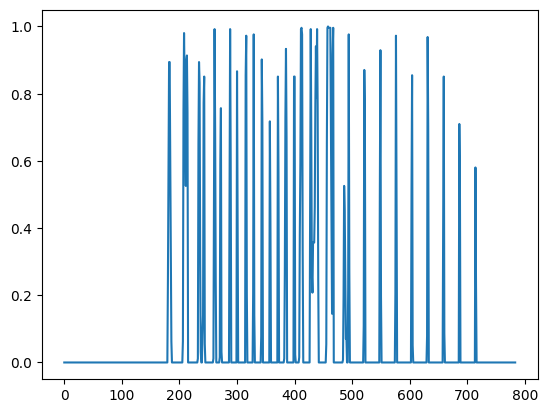

In [ ]:
import matplotlib.pyplot as plt
plt.plot(input_array)

In [ ]:
binary_array = []
i = 0

while i < len(input_array):
    num = float(input_array[i])
    binary = num * 1024  # Fixed-point scaling
    a = int(binary)

    if num >= 0:
        binary_16bit = format(a, '016b')
    else:
        binary_16bit = format((1 << 16) + a, '016b')  # Two's complement for negative values

    binary_array.append(binary_16bit)
    i += 1

# Optional: print first few to confirm
print("First 10 binary values:")
print(binary_array[:10])


First 10 binary values:
['0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000']


In [ ]:
# Check for any entries longer than 16 bits
for idx, val in enumerate(binary_array):
    if len(val) == 17:
        print(f"⚠️  Index {idx} has a value with {len(val)} bits: {val}")


inputs[0] = 16'b0000000000000000;

In [ ]:
with open("binary_output.txt", "w") as file:
    for binary_val in binary_array:
        file.write(binary_val+"," + "\n")

print("✅ Binary array successfully written to 'binary_output.txt'")


✅ Binary array successfully written to 'binary_output.txt'


In [ ]:
with open("new_output.txt", "w") as file:
    for idx,binary_val in enumerate(binary_array):
        file.write("inputs[" + str(idx) + "]= 16'b"+ binary_val+";" + "\n")

print("✅ Binary array successfully written to 'binary_output.txt'")

✅ Binary array successfully written to 'binary_output.txt'


In [ ]:
# Read the file and process the contents
file_path = 'weights_sigmoid_mnist_comma.txt'  # Update the file path if needed

# Initialize an empty list to store the indexes where changes are made
changed_indexes = []

# Open the file and read its contents
with open(file_path, 'r') as file:
    lines = file.readlines()

# Iterate through each line and each value
for line_num, line in enumerate(lines):
    values = line.strip().split(',')  # Assuming the values are comma-separated

    for idx, value in enumerate(values):
        if value == '10000000000000000':  # Check for the specific value
            values[idx] = '0000000000000000'  # Replace with the new value
            changed_indexes.append((line_num, idx))  # Store the index of the change

    # Join the values back into a string and update the line
    lines[line_num] = ','.join(values) + '\n'

# Save the modified file as 'weights_sigmoid_mnist_comma_updated.txt'
output_file_path = 'weights_sigmoid_mnist_comma_updated.txt'
with open(output_file_path, 'w') as file:
    file.writelines(lines)

# Return the indexes where changes were made
print("Changes made at the following indexes (line, index):")
print(changed_indexes)


Changes made at the following indexes (line, index):
[(288, 0), (1267, 0), (1295, 0), (1495, 0), (1722, 0), (1991, 0), (2110, 0), (2157, 0), (2395, 0), (2437, 0), (2931, 0), (3362, 0), (3457, 0), (4024, 0), (4203, 0), (4677, 0), (5004, 0), (5171, 0), (5190, 0), (5584, 0), (5617, 0), (6990, 0), (7059, 0), (7562, 0), (7654, 0), (7691, 0), (7983, 0), (8145, 0), (8522, 0), (8676, 0), (8975, 0), (8986, 0), (9021, 0), (9403, 0), (9434, 0), (10142, 0), (10574, 0), (10591, 0), (10705, 0), (10903, 0), (11077, 0), (11223, 0), (11629, 0), (11790, 0), (12021, 0), (12582, 0), (13292, 0), (13410, 0), (13887, 0), (14641, 0), (15169, 0), (15197, 0), (16163, 0), (16336, 0), (17296, 0), (18325, 0), (18552, 0), (18984, 0), (19256, 0), (19322, 0), (19882, 0), (20262, 0), (21199, 0), (21492, 0), (21958, 0), (22071, 0), (22394, 0), (22729, 0), (23352, 0), (23530, 0), (23646, 0), (23882, 0), (24132, 0), (24142, 0), (24490, 0), (24877, 0), (25890, 0), (26147, 0), (26594, 0), (26612, 0), (27145, 0), (27301, 0)

Test on 16 bit precision

In [ ]:
def binary16_to_float(binary_str):
    assert len(binary_str) == 16, "Binary string must be 16 bits"

    sign = -1 if binary_str[0] == '1' else 1
    integer_part = int(binary_str[1:6], 2)
    fractional_part = int(binary_str[6:], 2) / (2 ** 10)

    return sign * (integer_part + fractional_part)


In [ ]:
decimal_array = []
with open("input_binary.txt", "r") as file:
    for line in file:
        if line.strip():  # skip empty lines
            decimal_array.append(binary16_to_float(line.strip()))

input_array = np.array(decimal_array, dtype=np.float32)

In [ ]:
import numpy as np
import tensorflow as tf

def binary16_to_float(binary_str):
    binary_str = binary_str.strip()

    if len(binary_str) != 16:
        binary_str = "0000000000000000"

    # Convert full 16-bit binary to signed integer (handling two's complement)
    int_val = int(binary_str, 2)
    if int_val >= 2**15:  # Check if negative in 2's complement
        int_val -= 2**16

    # Convert back to float using fixed-point scaling
    return int_val / 1024.0

num=binary16_to_float(str(1111111100000101)) #-0.245117
print(num)
# 📂 Load input
with open("/content/9_num.txt", "r") as f:
    input_vals = [binary16_to_float(line) for line in f if line.strip()]
input_array1=np.array(input_vals, dtype=np.float32)
input_array = np.array(input_vals, dtype=np.float32).reshape(1, 28, 28)

# 📂 Load weights (flattened with padding)
with open("/content/sigmoid_weights.txt", "r") as f:
    weights_vals = [binary16_to_float(line) for line in f if line.strip()]
weights_vals = np.array(weights_vals, dtype=np.float32)



# 🔁 Reshape back from flat list
# Layer 1: 784×64 = 50176
# Layer 2: 64×10 = 640 (from 64×64 padded block)

w1_flat = weights_vals[:784 * 64]
w2_flat = weights_vals[784 * 64 : 784 * 64 + 64 * 64]  # second block

w1 = w1_flat.reshape((784, 64))
w2_full = w2_flat.reshape((64, 64))
w2 = w2_full[:, :10]  # trim to actual number of outputs

# 📂 Load biases
with open("/content/sigmoid_bias.txt", "r") as f:
    bias_vals = [binary16_to_float(line) for line in f if line.strip()]
bias_vals = np.array(bias_vals, dtype=np.float32)

b1 = bias_vals[:64]
b2 = bias_vals[64:74]  # next 10

#checker
for weights in weights_vals:
  if weights>1 or weights<-1:
    print("oob detected in weights")
for bias in bias_vals:
  if bias>1 or bias<-1:
    print("oob detected in bias")
for ips in input_array1:
  if ips>1 or ips<-1:
    print("oob detected in ips")

# 🧠 Define the model structure
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)
])
#model.build(input_shape=(1, 28, 28))

# 🧩 Set model weights
model.layers[1].set_weights([w1, b1])
model.layers[2].set_weights([w2, b2])

# 🚀 Run prediction
output = model.predict(input_array)

# 🧠 Show full output of the last Dense layer (logits or softmax inputs)
print("\n📊 Final Layer Output (10 raw values):")
print(output[0])  # [0] because batch size = 1

# 🎯 Predicted class
predicted_label = np.argmax(output)
print("\n✅ Predicted Label:", predicted_label)
predicted_label = np.argmax(output)

print("🧠 Model Output:", output)
print("🎯 Predicted Label:", predicted_label)


-0.2451171875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

📊 Final Layer Output (10 raw values):
[-1.307642    1.6424227  -0.22620583 -3.6669445   1.4355907   1.8929176
 -0.9432297   1.6240625  -3.6339684  -1.2661057 ]

✅ Predicted Label: 5
🧠 Model Output: [[-1.307642    1.6424227  -0.22620583 -3.6669445   1.4355907   1.8929176
  -0.9432297   1.6240625  -3.6339684  -1.2661057 ]]
🎯 Predicted Label: 5


In [ ]:
import numpy as np
import tensorflow as tf

def binary16_to_float(binary_str):
    binary_str = binary_str.strip()

    if len(binary_str) != 16:
        binary_str = "0000000000000000"

    # Convert full 16-bit binary to signed integer (handling two's complement)
    int_val = int(binary_str, 2)
    if int_val >= 2**15:  # Check if negative in 2's complement
        int_val -= 2**16

    # Convert back to float using fixed-point scaling
    return int_val / 1024.0

num = binary16_to_float(str(1111111100000101)) #-0.245117
print(num)

# 📂 Load input
with open("/content/input_binary_2.txt", "r") as f:
    input_vals = [binary16_to_float(line) for line in f if line.strip()]
input_array1 = np.array(input_vals, dtype=np.float32)
input_array = np.array(input_vals, dtype=np.float32).reshape(1, 28, 28)

# 📂 Load weights (flattened with padding)
with open("/content/sigmoid_weights.txt", "r") as f:
    weights_vals = [binary16_to_float(line) for line in f if line.strip()]
weights_vals = np.array(weights_vals, dtype=np.float32)

# 🔁 Reshape back from flat list
w1_flat = weights_vals[:784 * 64]
w2_flat = weights_vals[784 * 64 : 784 * 64 + 64 * 64]  # second block

w1 = w1_flat.reshape((784, 64))
w2_full = w2_flat.reshape((64, 64))
w2 = w2_full[:, :10]  # trim to actual number of outputs

# 📂 Load biases
with open("/content/9_num.txt", "r") as f:
    bias_vals = [binary16_to_float(line) for line in f if line.strip()]
bias_vals = np.array(bias_vals, dtype=np.float32)

b1 = bias_vals[:64]
b2 = bias_vals[64:74]  # next 10

#checker
for weights in weights_vals:
  if weights > 1 or weights < -1:
    print("oob detected in weights")
for bias in bias_vals:
  if bias > 1 or bias < -1:
    print("oob detected in bias")
for ips in input_array1:
  if ips > 1 or ips < -1:
    print("oob detected in ips")

# 🧠 Define the model structure
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])

# 🧩 Set model weights
model.layers[1].set_weights([w1, b1])
model.layers[2].set_weights([w2, b2])

# Define a custom function to monitor layer outputs and check the value range
def check_intermediate_values(layer_outputs, layer_name):
    if np.any(layer_outputs > 1) or np.any(layer_outputs < -1):
        print(f"⚠️ Out-of-Bounds detected in {layer_name}!")
        print(f"layer output {layer_outputs}")
        print(f"{layer_name} output range: Min = {np.min(layer_outputs)}, Max = {np.max(layer_outputs)}")

# Add hooks for intermediate layer outputs
# First, define a custom model with hooks
class MyModel(tf.keras.Model):
    def __init__(self, base_model):
        super(MyModel, self).__init__()
        self.base_model = base_model

    def call(self, inputs, training=False):
        # Layer 1 (Flatten) output
        x = self.base_model.layers[0](inputs)
        check_intermediate_values(x.numpy(), "Flatten Layer")

        # Layer 2 (Dense + ReLU) output
        x = self.base_model.layers[1](x)
        check_intermediate_values(x.numpy(), "ReLU Layer")

        # Layer 3 (Dense) output
        x = self.base_model.layers[2](x)
        check_intermediate_values(x.numpy(), "Output Layer")

        return x

# Create the model with the custom class
custom_model = MyModel(model)

# 🚀 Run prediction
output = custom_model(input_array)

# 🧠 Show full output of the last Dense layer (logits or softmax inputs)
print("\n📊 Final Layer Output (10 raw values):")
print(output[0])  # [0] because batch size = 1

# 🎯 Predicted class
predicted_label = np.argmax(output)
print("\n✅ Predicted Label:", predicted_label)


-0.2451171875

📊 Final Layer Output (10 raw values):
tf.Tensor(
[0.17790206 0.08674706 0.9901589  0.46039918 0.1365747  0.4050762
 0.16085711 0.11029727 0.3611843  0.04754891], shape=(10,), dtype=float32)

✅ Predicted Label: 2


In [ ]:
import numpy as np
import tensorflow as tf

def binary16_to_float(binary_str):
    binary_str = binary_str.strip()
    if len(binary_str) != 16:
        binary_str = "0000000000000000"
    int_val = int(binary_str, 2)
    if int_val >= 2**15:
        int_val -= 2**16
    return int_val / 1024.0

# Load inputs, weights, and biases (same as your code)...

# Model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(10 , activation='sigmoid' )
])
model.layers[1].set_weights([w1, b1])
model.layers[2].set_weights([w2, b2])

# 👁️ Detailed neuron-level monitoring
def check_neuron_outputs(values, layer_name):
    values_np = values.numpy().reshape(-1)  # convert to flat NumPy array
    print(f"\n🔍 {layer_name}: Checking {len(values_np)} neurons")
    for i, v in enumerate(values_np):
        if v < -1 or v > 1:
            print(f"⚠️ Neuron {i}: OOB value = {v:.6f}")
    print(f"✅ {layer_name} Min: {np.min(values_np):.6f}, Max: {np.max(values_np):.6f}")


# Forward pass step by step with neuron output check
flatten_output = model.layers[0](input_array)  # shape: (1, 784)
dense1_linear = tf.matmul(flatten_output, w1) + b1  # before activation
dense1_activated = tf.nn.relu(dense1_linear)

dense2_output = tf.matmul(dense1_activated, w2) + b2

# 🧠 Check each stage
check_neuron_outputs(flatten_output, "Flatten Layer")
check_neuron_outputs(dense1_linear, "Dense Layer 1 (pre-Sigmoid")
check_neuron_outputs(dense1_activated, "Dense Layer 1 (post-Sigmoid)")
check_neuron_outputs(dense2_output, "Output Layer (Dense Layer 2)")

# 🎯 Final Prediction
predicted_label = np.argmax(dense2_output.numpy())
print("\n✅ Predicted Label:", predicted_label)



🔍 Flatten Layer: Checking 784 neurons
✅ Flatten Layer Min: 0.000000, Max: 0.000000

🔍 Dense Layer 1 (pre-Sigmoid: Checking 64 neurons
✅ Dense Layer 1 (pre-Sigmoid Min: -0.636719, Max: 1.000000

🔍 Dense Layer 1 (post-Sigmoid): Checking 64 neurons
✅ Dense Layer 1 (post-Sigmoid) Min: 0.000000, Max: 1.000000

🔍 Output Layer (Dense Layer 2): Checking 10 neurons
⚠️ Neuron 0: OOB value = -1.307642
⚠️ Neuron 1: OOB value = 1.642423
⚠️ Neuron 3: OOB value = -3.666945
⚠️ Neuron 4: OOB value = 1.435591
⚠️ Neuron 5: OOB value = 1.892918
⚠️ Neuron 7: OOB value = 1.624063
⚠️ Neuron 8: OOB value = -3.633968
⚠️ Neuron 9: OOB value = -1.266106
✅ Output Layer (Dense Layer 2) Min: -3.666945, Max: 1.892918

✅ Predicted Label: 5


Advay wala change

In [ ]:
#let n be the number of neurons in this layer and m be the number of neurons in the next layer
n_layers=weights_3d.shape[0]
print(n_layers)
iterative_sequence=[]
for i, w in enumerate(weights_3d):
    print(f"\n📦 weights_3d[{i}] shape: {w.shape}")
    #print(w)
    current_layer=weights_3d[i]
    n=current_layer.shape[0]
    m=current_layer.shape[1]
    if i==0:

      for j in range(1024): #row index
          if (j<n):
            for k in range(64): #column index
              if(k<m):
                iterative_sequence.append(current_layer[j][k])
              elif(k>=m):
                  iterative_sequence.append(0)
          elif (j>=n):
            for k in range(64):
              iterative_sequence.append(0)
    else:
        for j in range(64): #row index
          if (j<n):
            for k in range(64): #column index
              if(k<m):
                iterative_sequence.append(current_layer[j][k])
              elif(k>=m):
                  iterative_sequence.append(0)
          elif (j>=n):
            for k in range(64):
              iterative_sequence.append(0)




    print(f"n={n}, m={m}")

2

📦 weights_3d[0] shape: (784, 64)
n=784, m=64

📦 weights_3d[1] shape: (64, 10)
n=64, m=10
